<a href="https://colab.research.google.com/github/SarahSaeedKhan/DTI/blob/main/Unet_normalized__undersample_FA__and_MD_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Path to your 4D NIfTI DTI file
file_path = '/content/drive/MyDrive/dwi.nii.gz'

# Directory to save the converted 3D NIfTI files
output_3d_directory = '/content/output_directory'
os.makedirs(output_3d_directory, exist_ok=True)

# Load the 4D NIfTI file
nifti_image = nib.load(file_path)

# Access the image data as a NumPy array
image_data_4d = nifti_image.get_fdata()

# Get the number of directions
num_directions = image_data_4d.shape[3]

# Create a list to store 2D slices
slices_2d = []

# Convert 4D to 3D for each direction and store the 2D slices
for direction_idx in range(num_directions):
    # Create a new 3D NIfTI image with the converted data
    image_data_3d = image_data_4d[..., direction_idx]

    # Store the 2D slices in the list
    for slice_idx in range(image_data_3d.shape[2]):
        slices_2d.append(image_data_3d[:, :, slice_idx])

# Convert the list of 2D slices to a NumPy array
slices_2d_array = np.array(slices_2d)

# Now you have a NumPy array (slices_2d_array) containing all the 2D slices

# You can access individual slices like this:
# slice = slices_2d_array[index]

# If needed, you can save this NumPy array to a file using np.save
np.save('slices_2d_array.npy', slices_2d_array)


In [ ]:
# Assuming slices_2d_array contains your 2D slices data

# Define the split ratios
train_ratio = 0.8  # 80% of data for training
val_ratio = 0.1    # 10% of data for validation, remaining 10% for testing

# Calculate the number of samples for each split
total_samples = slices_2d_array.shape[0]
num_train_samples = int(total_samples * train_ratio)
num_val_samples = int(total_samples * val_ratio)

# Split the data
X_train = slices_2d_array[:num_train_samples]
X_test = slices_2d_array[num_train_samples:]


# Print the shapes of the splits
print("Training data shape:", X_train.shape)
# print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)


Training data shape: (3273, 128, 128)
Test data shape: (819, 128, 128)


In [ ]:
# Calculate mean and standard deviation from the training data
mean_value = np.mean(X_train)
std_dev = np.std(X_train)

# Normalize the training data
X_train = (X_train - mean_value) / std_dev

# Normalize the validation data using the same mean and standard deviation
# X_val = (X_val - mean_value) / std_dev

# Normalize the test data using the same mean and standard deviation
X_test = (X_test - mean_value) / std_dev

# Print the shapes of the normalized data
print("Normalized Training data shape:", X_train.shape)
# print("Normalized Validation data shape:", X_val.shape)
print("Normalized Test data shape:", X_test.shape)


Normalized Training data shape: (3273, 128, 128)
Normalized Test data shape: (819, 128, 128)


In [ ]:
import numpy as np

# Define the shape of the zero array
shape = (819, 128, 128)

# Create a zero array with the specified shape
zero_array = np.zeros(shape, dtype=np.float32)

# Print the shape to verify
print(zero_array.shape)


(819, 128, 128)


In [ ]:
import numpy as np


# Combine X_train and zero_array
combined_data = np.concatenate((X_train, zero_array), axis=0)

# Print the shape of the combined data to verify
print(combined_data.shape)


(4092, 128, 128)


In [ ]:

Y_train=slices_2d_array

In [ ]:
print(Y_train.shape)

(4092, 128, 128)


In [ ]:
mean_value = np.mean(Y_train)
std_dev = np.std(Y_train)

In [ ]:
# Normalize the training data
Y_train = (Y_train - mean_value) / std_dev

In [ ]:
import numpy as np
from keras import backend as keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
#from tensorflow.python.keras.layers import Input, Conv2D, Conv1D,MaxPooling2D,Flatten, Dense, concatenate, Conv2DTranspose
#from tensorflow.python.keras.layers import Activation, Dropout,UpSampling2D,merge
#from tensorflow.python.keras.models import Model
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras import initializers


In [ ]:
def get_unet(img_rows,img_cols):


    input_layer = Input((img_rows, img_cols,1),name='inputs')
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',use_bias=False,kernel_initializer = 'RandomNormal')(input_layer)
    # weights are intialized according to gaussian mean =0 ,std dev=0.05
    conv1=BatchNormalization()(conv1)
    #Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for
    #each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the no.of
    #training epoches

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same',use_bias=False, kernel_initializer = 'RandomNormal')(conv1)
    conv2=BatchNormalization()(conv2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)


    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same',use_bias=False, kernel_initializer = 'RandomNormal')(pool1)
    conv3=BatchNormalization()(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same',use_bias=False, kernel_initializer = 'RandomNormal')(conv3)
    conv4=BatchNormalization()(conv4)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)


    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same',use_bias=False, kernel_initializer = 'RandomNormal')(pool2)
    conv5=BatchNormalization()(conv5)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same',use_bias=False, kernel_initializer = 'RandomNormal')(conv5)
    conv6=BatchNormalization()(conv6)


    up_pool1=UpSampling2D(size = (2,2))(conv6)


    merge6 =concatenate([up_pool1,conv4], axis=3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same',use_bias=False, kernel_initializer = 'RandomNormal')(merge6)
    conv7=BatchNormalization()(conv7)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', use_bias=False,kernel_initializer = 'RandomNormal')(conv7)
    conv8=BatchNormalization()(conv8)

    up_pool2=UpSampling2D(size = (2,2))(conv8)
    merge9 = concatenate([conv2,up_pool2], axis=3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',use_bias=False, kernel_initializer = 'RandomNormal')(merge9)
    conv9=BatchNormalization()(conv9)
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same',use_bias=False, kernel_initializer = 'RandomNormal')(conv9)
    conv10=BatchNormalization()(conv10)
    conv11 = Conv2D(1, 1, activation = 'relu', padding = 'same',use_bias=False, kernel_initializer = 'RandomNormal')(conv10)

    model = Model(inputs = input_layer, outputs = conv11, name='get_unet')
    RMSprop=optimizers.RMSprop(lr=0.001)

    model.compile(optimizer = RMSprop, loss = 'mean_squared_error', metrics = ['accuracy'])
    # metrics : perfomance of model
    # mean squared error :always non – negative and values close to zero are better

    return model


In [ ]:
model=get_unet(128,128)
model.summary()

Model: "get_unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         576       ['inputs[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36864     ['batch_normalization[0

In [ ]:
from datetime import datetime
model =get_unet(128,128)
print("got unet")

callbacks = [
    EarlyStopping(patience=300, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, verbose=1),
    ModelCheckpoint('DWI_Vdensity_brain.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
]

print('Fitting model...')

start = datetime.now()
history=model.fit(combined_data, Y_train, batch_size=32, epochs =50,validation_split=0.1, verbose=1, shuffle=True, callbacks=callbacks)#model_checkpoint
model.save('unet_DWI_Vdensity_brain.h5')

stop = datetime.now()
print("Time taken to execute:" + str(stop - start))

got unet
Fitting model...
Epoch 1/50
116/116 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.01374, saving model to DWI_Vdensity_brain.hdf5
116/116 [==============================] - 55s 298ms/step - loss: 0.3000 - accuracy: 0.0000e+00 - val_loss: 1.0137 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/116 [============================>.] - ETA: 0s - loss: 0.2782 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 1.01374 to 0.84240, saving model to DWI_Vdensity_brain.hdf5
116/116 [==============================] - 28s 242ms/step - loss: 0.2782 - accuracy: 0.0000e+00 - val_loss: 0.8424 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
115/116 [============================>.] - ETA: 0s - loss: 0.2656 - accuracy: 0.0000e+00
Epoch 3: val_loss did not improve from 0.84240
116/116 [==============================] - 29s 246ms/step - loss: 0.2656 - accuracy: 0.0000e+00 - val_loss: 0.8943 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/50
115/116 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.0000e+00
Epoch 4: val_loss did not improve from 0.84240
116/116 [==============================] - 29s 247ms/step - loss: 0.2674 - accuracy: 0.0000e+00 - val_loss: 0.8492 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/50
115/116 [============================>.] - ETA: 0

In [ ]:
print('predict test data')
imgs_mask_test = model.predict(X_test,batch_size=5, verbose=1)
np.save('AF2_DWI_Vdensity_brain.npy', imgs_mask_test)

predict test data
164/164 [==============================] - 4s 18ms/step


In [ ]:
print('predict test data')
imgs_mask_test_u = model.predict(zero_array,batch_size=5, verbose=1)
np.save('AF2_DWI_Vdensity_brain_test.npy', imgs_mask_test)

predict test data
164/164 [==============================] - 2s 13ms/step


(819, 128, 128, 1)


(<matplotlib.image.AxesImage at 0x7a81007665c0>, Text(0.5, 1.0, 'unet output'))

<Figure size 640x480 with 0 Axes>

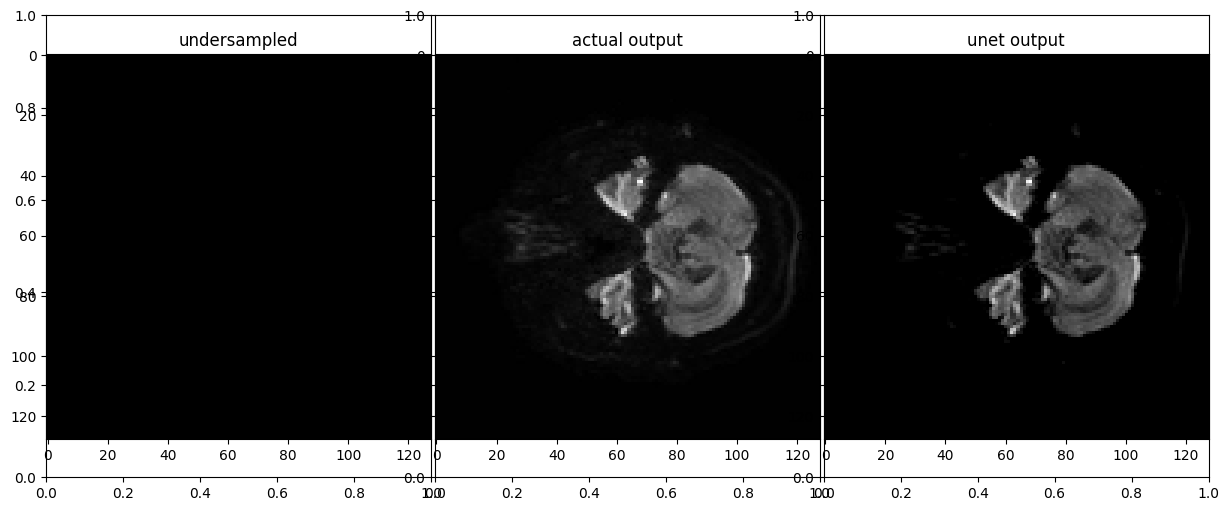

In [ ]:
import matplotlib.pyplot as plt
unet_out={}
unet_out=np.load('AF2_DWI_Vdensity_brain_test.npy')
print(unet_out.shape)
image_no=100
plt.figure()
fig, axs = plt.subplots(1,3, figsize=(15,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.01)
ax=fig.add_subplot(1,3,1)
plt.imshow(zero_array[image_no,:,:],cmap='gray'),plt.title('undersampled')
ax=fig.add_subplot(1,3,2)
plt.imshow(X_test[image_no,:,:],cmap='gray'),plt.title('actual output')
ax=fig.add_subplot(1,3,3)
plt.imshow(unet_out[image_no,:,:],cmap='gray'),plt.title('unet output')

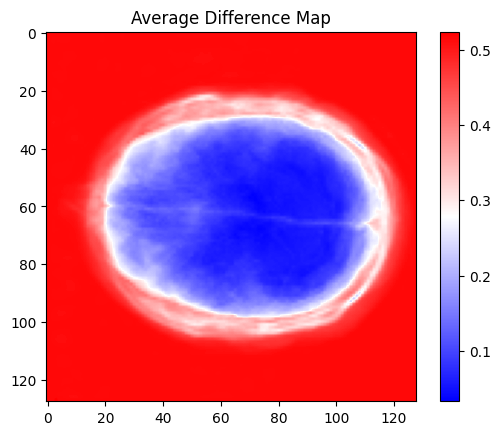

Average Difference Value: 0.36610918414184634


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the file
AF2_DWI_Vdensity_brain = np.load('AF2_DWI_Vdensity_brain_test.npy')


# Ensure both arrays have compatible shapes
AF2_DWI_Vdensity_brain = np.squeeze(AF2_DWI_Vdensity_brain)

# Calculate the difference map for each pair of images
difference_maps = np.abs(X_test - AF2_DWI_Vdensity_brain)

# Calculate the average difference map
average_difference_map = np.mean(difference_maps, axis=0)

# Display the average difference map
plt.imshow(average_difference_map, cmap='bwr')
plt.colorbar()
plt.title('Average Difference Map')
plt.show()

# Print the average difference value
average_difference_value = np.mean(average_difference_map)
print('Average Difference Value:', average_difference_value)


In [ ]:
# Assuming slices_2d_array contains your 2D slices data

# Define the split ratios
train_ratio = 0.8  # 80% of data for training
val_ratio = 0.1    # 10% of data for validation, remaining 10% for testing

# Calculate the number of samples for each split
total_samples = slices_2d_array.shape[0]
num_train_samples = int(total_samples * train_ratio)
num_val_samples = int(total_samples * val_ratio)

# Split the data
Y_train = slices_2d_array[:num_train_samples]
Y_test = slices_2d_array[num_train_samples:]


# Print the shapes of the splits
print("Training data shape:", Y_train.shape)
# print("Validation data shape:", X_val.shape)
print("Test data shape:", Y_test.shape)


Training data shape: (3273, 128, 128)
Test data shape: (819, 128, 128)


In [ ]:
import numpy as np

# Assuming you have already reshaped data_train and data_test
x_train = np.reshape(Y_train, (len(Y_train), 128, 128, 1))
# data_test = np.reshape(x_test, (len(x_test), 128, 128, 1))

# Combine test and train data
combined_data = np.vstack((x_train, imgs_mask_test_u))

# Check the shape of the combined data
print(combined_data.shape)


(4092, 128, 128, 1)


In [ ]:
import numpy as np

# Assuming you have loaded your slices into slices_2d_array
# slices_2d_array.shape should be (4092, 128, 128)

# Define dimensions
x_dim = 128
y_dim = 128
z_dim = 66  # Number of slices
num_directions = 62  # Number of directions

# Calculate the number of scans per group
scans_per_group = combined_data.shape[0] // num_directions

# Reshape the 2D slices into 3D groups (66, 128, 128)
slices_3d_groups = combined_data[:num_directions * scans_per_group].reshape(num_directions, scans_per_group, x_dim, y_dim)

# Create an empty 4D array to hold the result
reshaped_4d_array = np.empty((x_dim, y_dim, z_dim, num_directions))

# Fill the 4D array with 3D groups
for direction_idx in range(num_directions):
    reshaped_4d_array[..., direction_idx] = slices_3d_groups[direction_idx].transpose(1, 2, 0)

# Now reshaped_4d_array is a 4D array of shape (128, 128, 66, 62)

# To access individual slices in the 4D array:
# slice = reshaped_4d_array[:, :, :, direction_idx]


In [ ]:
import numpy as np
import nibabel as nib

# Assuming you have reshaped_4d_array as described in the previous code

# Create a NIfTI image from the reshaped 4D array
nifti_image_4d = nib.Nifti1Image(reshaped_4d_array, affine=None)

# Specify the output file path
output_nii_file = '/content/output_4d_file.nii'

# Save the 4D NIfTI image to a file
nib.save(nifti_image_4d, output_nii_file)


Average SSIM: 0.9758398680684666
Average PSNR: 55.69535037890818
Average Artifact Power (MSE): 0.17689058074687386


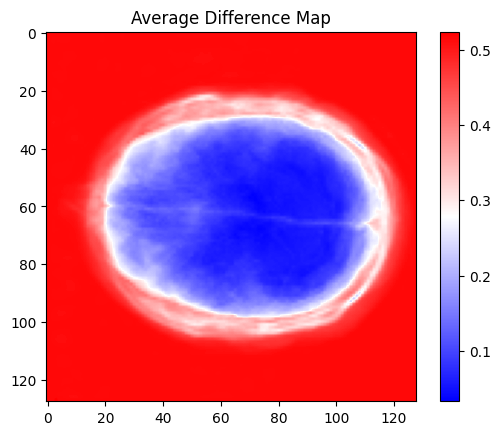

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Load the data from the file
AF2_DWI_Vdensity_brain = np.load('AF2_DWI_Vdensity_brain.npy')

# Assuming x_test is your original images loaded from somewhere
# Assuming AF2_DWI_Vdensity_brain is your loaded images from the file

# Ensure both arrays have compatible shapes
AF2_DWI_Vdensity_brain = np.squeeze(AF2_DWI_Vdensity_brain)

# Calculate SSIM, PSNR, and Artifact Power for each pair of images
ssim_values = []
psnr_values = []
artifact_power_values = []

for i in range(len(X_test)):
    # Calculate SSIM
    ssim_score, _ = ssim(X_test[i], AF2_DWI_Vdensity_brain[i], full=True, data_range=255)  # Assuming 8-bit images
    ssim_values.append(ssim_score)

    # Calculate PSNR
    psnr_value = psnr(X_test[i], AF2_DWI_Vdensity_brain[i], data_range=255)  # Assuming 8-bit images
    psnr_values.append(psnr_value)

    # Calculate Artifact Power (assuming you have a function to calculate it)
    mse = np.mean((X_test[i] - AF2_DWI_Vdensity_brain[i]) ** 2)  # Example using Mean Squared Error (MSE) as artifact power
    artifact_power_values.append(mse)

# Calculate the average SSIM, PSNR, and Artifact Power
average_ssim = np.mean(ssim_values)
average_psnr = np.mean(psnr_values)
average_artifact_power = np.mean(artifact_power_values)

# Print the results
print('Average SSIM:', average_ssim)
print('Average PSNR:', average_psnr)
print('Average Artifact Power (MSE):', average_artifact_power)

# Display the average difference map
average_difference_map = np.mean(np.abs(X_test - AF2_DWI_Vdensity_brain), axis=0)
plt.imshow(average_difference_map, cmap='bwr')
plt.colorbar()
plt.title('Average Difference Map')
plt.show()


In [ ]:
!pip install dipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 53.2 MB/s eta 0:00:00


In [ ]:
import nibabel as nib
import dipy.reconst.dti as dti

# Load DTI data
dti_data = nib.load('/content/output_4d_file.nii')  # Replace with your DTI data file

# Load b-values and b-vectors
bvals = '/content/drive/MyDrive/dwi.bval'  # Replace with the path to your b-values file
bvecs = '/content/drive/MyDrive/dwi.bvec'  # Replace with the path to your b-vectors file

# Create a gradient table
gtab = dti.gradient_table(bvals, bvecs)

# Create a DTI model
dti_model = dti.TensorModel(gtab)

# Fit the DTI model to the data
dti_fit = dti_model.fit(dti_data.get_fdata())

# Calculate the Fractional Anisotropy (FA) map
fa_map = dti_fit.fa

# Save the FA map as a NIfTI file (optional)
fa_img = nib.Nifti1Image(fa_map, dti_data.affine)
nib.save(fa_img, 'fa_map.nii.gz')  # Replace with your desired output filename


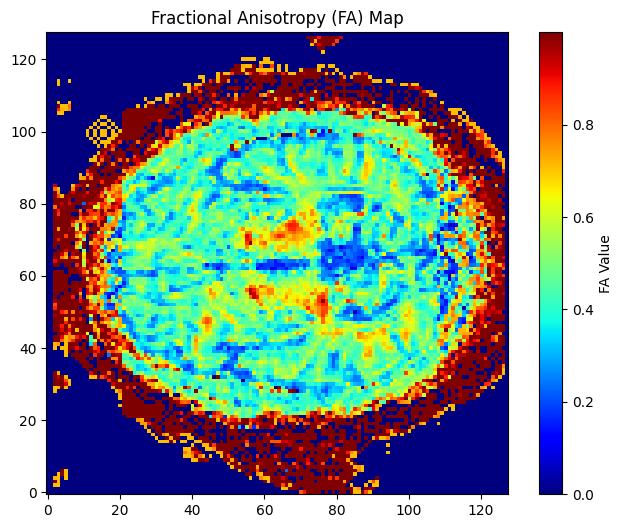

FA value at coordinates (30, 30, 5): 0.0000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Display the FA map
plt.figure(figsize=(8, 6))
plt.imshow(fa_map[:, :, 25], cmap='jet', origin='lower')
plt.colorbar(label='FA Value')
plt.title('Fractional Anisotropy (FA) Map')
plt.show()

# Print FA values at specific coordinates (e.g., voxel at (30, 30, 25))
x, y, z = 30, 30, 5
fa_value = fa_map[x, y, z]
print(f'FA value at coordinates ({x}, {y}, {z}): {fa_value:.4f}')

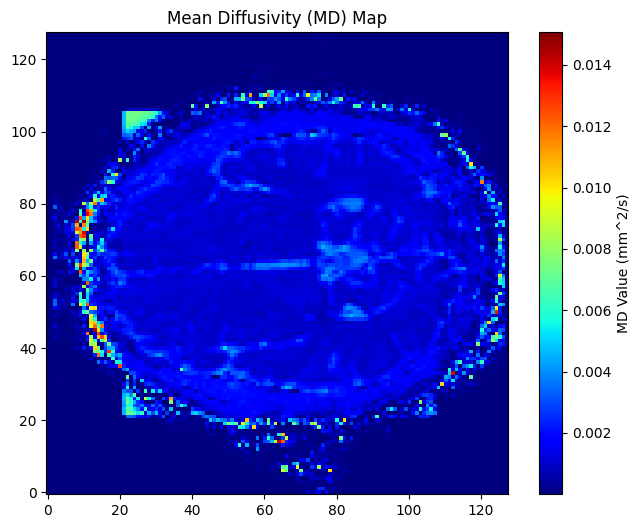

MD value at coordinates (40, 40, 25): 0.0014 mm^2/s


In [ ]:
import nibabel as nib
import dipy.reconst.dti as dti
import matplotlib.pyplot as plt
import numpy as np

# Load DTI data
dti_data = nib.load('/content/output_4d_file.nii')  # Replace with your DTI data file

# Load b-values and b-vectors
bvals = '/content/drive/MyDrive/dwi.bval'  # Replace with the path to your b-values file
bvecs = '/content/drive/MyDrive/dwi.bvec'  # Replace with the path to your b-vectors file

# Create a gradient table
gtab = dti.gradient_table(bvals, bvecs)

# Create a DTI model
dti_model = dti.TensorModel(gtab)

# Fit the DTI model to the data
dti_fit = dti_model.fit(dti_data.get_fdata())

# Calculate the Mean Diffusivity (MD) map
md_map = dti_fit.md  # MD is obtained directly from the DTI fit

# Display the MD map
plt.figure(figsize=(8, 6))
plt.imshow(md_map[:, :, 25], cmap='jet', origin='lower')
plt.colorbar(label='MD Value (mm^2/s)')
plt.title('Mean Diffusivity (MD) Map')
plt.show()

# Print MD values at specific coordinates (e.g., voxel at (30, 30, 25))
x, y, z = 40, 40, 25
md_value = md_map[x, y, z]
print(f'MD value at coordinates ({x}, {y}, {z}): {md_value:.4f} mm^2/s')


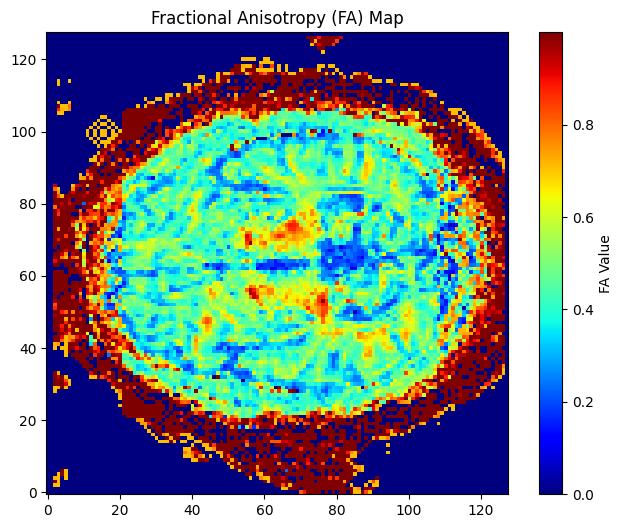

FA value at coordinates (50, 50, 5): 0.7015


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Display the FA map
plt.figure(figsize=(8, 6))
plt.imshow(fa_map[:, :, 25], cmap='jet', origin='lower')
plt.colorbar(label='FA Value')
plt.title('Fractional Anisotropy (FA) Map')
plt.show()

# Print FA values at specific coordinates (e.g., voxel at (30, 30, 25))
x, y, z = 50, 50,5
fa_value = fa_map[x, y, z]
print(f'FA value at coordinates ({x}, {y}, {z}): {fa_value:.4f}')

In [ ]:
# Calculate the average of 2D images along the first axis (axis=0)
average_image = np.mean(slices_2d_array, axis=0)

# Now, average_image contains the average of all 2D images


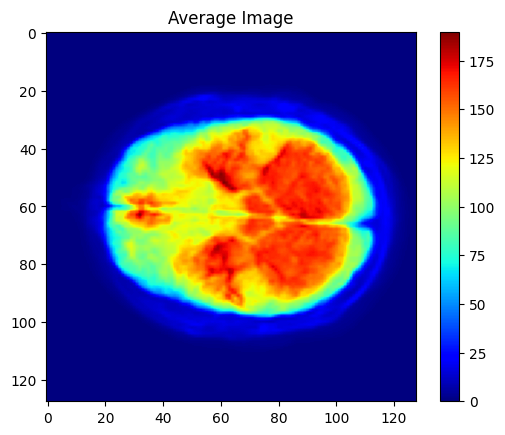

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'average_image' is the 2D NumPy array representing the average image
plt.imshow(average_image, cmap='jet')  # 'cmap' specifies the color map (grayscale in this case)
plt.title('Average Image')
plt.colorbar()  # Add a colorbar to the right of the image
plt.show()


In [ ]:
average_image_generated = np.mean(combined_data, axis=0)

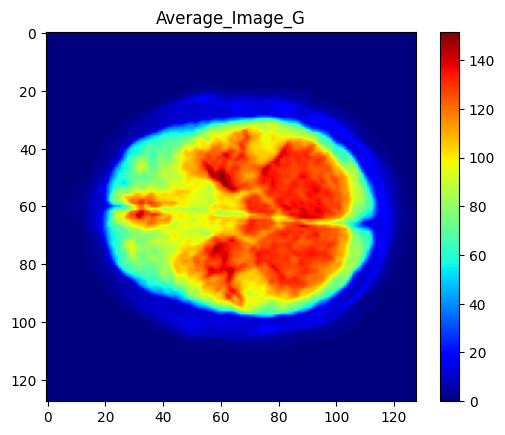

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'average_image' is the 2D NumPy array representing the average image
plt.imshow(average_image_generated, cmap='jet')  # 'cmap' specifies the color map (grayscale in this case)
plt.title('Average_Image_G')
plt.colorbar()  # Add a colorbar to the right of the image
plt.show()

In [ ]:
u_data = np.concatenate((X_train, zero_array), axis=0)
average_image_generated_u = np.mean(u_data, axis=0)

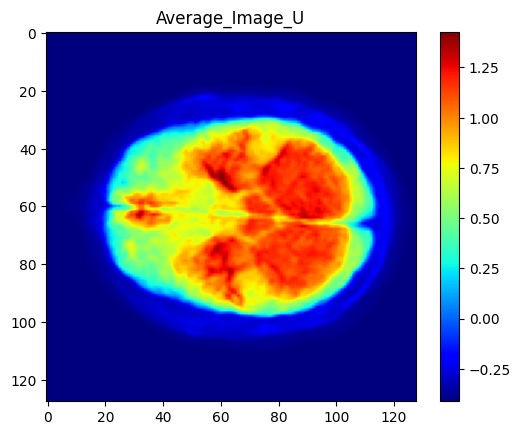

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'average_image' is the 2D NumPy array representing the average image
plt.imshow(average_image_generated_u, cmap='jet')  # 'cmap' specifies the color map (grayscale in this case)
plt.title('Average_Image_U')
plt.colorbar()  # Add a colorbar to the right of the image
plt.show()

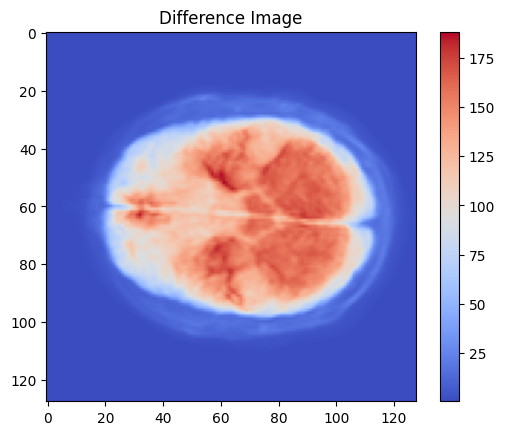

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'original_image' is the 2D NumPy array representing an original image
# Assuming 'average_image' is the 2D NumPy array representing the average image

# Calculate the difference between the original image and the average image
difference_image = average_image - average_image_generated_u

# Display the difference image
plt.imshow(difference_image, cmap='coolwarm')  # 'cmap' specifies the color map (coolwarm in this case)
plt.title('Difference Image')
plt.colorbar()  # Add a colorbar to the right of the image
plt.show()


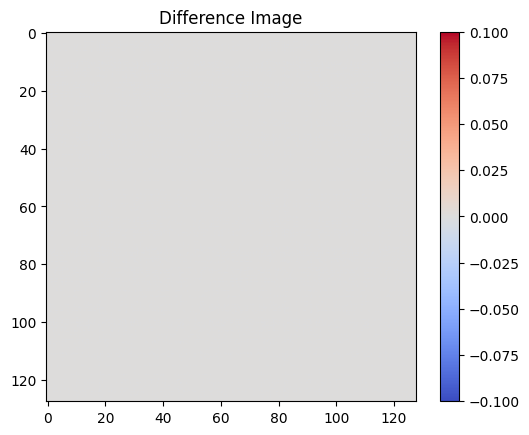

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'original_image' is the 2D NumPy array representing an original image
# Assuming 'average_image' is the 2D NumPy array representing the average image

# Calculate the difference between the original image and the average image
difference_image = average_image - average_image

# Display the difference image
plt.imshow(difference_image, cmap='coolwarm')  # 'cmap' specifies the color map (coolwarm in this case)
plt.title('Difference Image')
plt.colorbar()  # Add a colorbar to the right of the image
plt.show()
